In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
#read data
df = pd.read_csv("RFLFSODataFull.csv")

In [3]:
#import variables
variables = {
    'Overall_FSO_Att': ['Time', 'TemperatureDifference', 'TemperatureMin', 'AbsoluteHumidity', 'ParticulateMin*Distance', 'Temperature*Distance', 'Distance', 'Visibility*Distance'],
    'Overall_RFL_Att': ['Frequency', 'Visibility', 'RelativeHumidity', 'Distance', 'Distance*RainIntensity', 'AbsoluteHumidity'],

    'SynopCode_0_FSO_Att': ['Time', 'Temperature*Distance', 'AbsoluteHumidity*Visibility', 'TemperatureMax', 'TemperatureMin', 'AbsoluteHumidity*Distance', 'AbsoluteHumidity*Temperature', 'Visibility*Distance', 'Temperature', 'Distance'],
    'SynopCode_0_RFL_Att': ['Visibility*AbsoluteHumidity', 'AbsoluteHumidity*Distance', 'Frequency*Distance', 'Temperature*Distance', 'Distance'],

    'SynopCode_3_FSO_Att': ['RelativeHumidity*Time', 'VisibilityMax*Distance', 'RelativeHumidity*Distance'],
    'SynopCode_3_RFL_Att': ['Frequency', 'RelativeHumidity', 'AbsoluteHumidity', 'Temperature', 'AbsoluteHumidityMax', 'TemperatureMin', 'Time', 'AbsoluteHumidityMin', 'TemperatureMax*AbsoluteHumidityMin'],

    'SynopCode_4_FSO_Att': ['Visibility*Distance', 'WindSpeedMax', 'TemperatureMax', 'Distance', 'Temperature', 'Distance*Particulate', 'Particulate*ParticulateMax'],
    'SynopCode_4_RFL_Att': ['TemperatureMin', 'RainIntensity*RelativeHumidity', 'AbsoluteHumidity', 'RelativeHumidity'],

    'SynopCode_5_FSO_Att': ['Temperature*Distance', 'Visibility*Distance', 'Temperature*Visibility', 'ParticulateMax', 'Distance'],
    'SynopCode_5_RFL_Att': ['RainIntensityMax*AbsoluteHumidityMax', 'AbsoluteHumidityMin', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'AbsoluteHumidityMax*AbsoluteHumidity'],

    'SynopCode_6_FSO_Att': ['Temperature*Distance', 'Visibility*Distance', 'ParticulateMax*Distance', 'Distance', 'Distance*Particulate'],
    'SynopCode_6_RFL_Att': ['RelativeHumidity', 'ParticulateMin', 'AbsoluteHumidity*RainIntensity', 'Distance*AbsoluteHumidity', 'Visibility*AbsoluteHumidity', 'Distance*RainIntensityMax', 'AbsoluteHumidity', 'Distance*RainIntensity'],

    'SynopCode_7_FSO_Att': ['TemperatureDifference*Temperature', 'Temperature', 'Particulate', 'ParticulateMax', 'TemperatureDifference', 'ParticulateMax*Particulate', 'ParticulateMin*Particulate'],
    'SynopCode_7_RFL_Att': ['RelativeHumidity', 'RainIntensityMin', 'Visibility', 'RainIntensityMin*WindSpeedMax', 'AbsoluteHumidity', 'TemperatureDifference*RainIntensityMin'],

    'SynopCode_8_FSO_Att': ['AbsoluteHumidity', 'Distance', 'Visibility'],
    'SynopCode_8_RFL_Att': ['Frequency', 'TemperatureDifference', 'Distance', 'VisibilityMax', 'RainIntensityMin', 'AbsoluteHumidityMax', 'RainIntensityMin*AbsoluteHumidityMax', 'AbsoluteHumidity']
}

In [4]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()

68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

In [5]:
#define function to create interaction
def create_interaction_terms(df, interaction_vars):
    df_interactions=pd.DataFrame()
    for var in interaction_vars:
        if '*' in var:
            var1, var2 = var.split('*')
            df_interactions[var] = df[var1] * df[var2]
        else:
            df_interactions[var] = df[var]
    return df_interactions

In [6]:
# Initialize results
results = {}
#define function to train and evaluate
def train_and_evaluate_rf(Xtrain, Xtest, ytrain, ytest, response_var, model_name):
    rf_model = RandomForestRegressor(n_estimators=200, random_state=1874845)
    rf_model.fit(Xtrain, ytrain)
    
    y_pred_train = rf_model.predict(Xtrain)
    y_pred_test = rf_model.predict(Xtest)
    
    train_rmse = np.sqrt(mean_squared_error(ytrain, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(ytest, y_pred_test))
    
    train_r2 = r2_score(ytrain, y_pred_train)
    test_r2 = r2_score(ytest, y_pred_test)
    results[model_name] = {'rmse': test_rmse, 'r2': test_r2}
    if 'FSO' in model_name:
        X_test_fso=X_test[X_test['SYNOPCode']==int(model_name.split('_')[1])].reset_index(drop=True)
        X_overall_fso_test=create_interaction_terms(X_test_fso,variables['Overall_FSO_Att'])
        overall_y_pred=Overall_FSO_Att.predict(X_overall_fso_test)
        overall_r2=r2_score(ytest, overall_y_pred)
        overall_rmse=np.sqrt(mean_squared_error(ytest, overall_y_pred))
        results[f"{model_name}_overall"] = {'rmse': overall_rmse, 'r2': overall_r2}
    if 'RFL' in model_name:
        X_test_rfl=X_test[X_test['SYNOPCode']==int(model_name.split('_')[1])].reset_index(drop=True)
        X_overall_rfl_test=create_interaction_terms(X_test_rfl,variables['Overall_RFL_Att'])
        overall_y_pred=Overall_RFL_Att.predict(X_overall_rfl_test)
        overall_r2=r2_score(ytest, overall_y_pred)
        overall_rmse=np.sqrt(mean_squared_error(ytest, overall_y_pred))
        results[f"{model_name}_overall"] = {'rmse': overall_rmse, 'r2': overall_r2}

    print(f"Train RMSE for {response_var}: {train_rmse}")
    print(f"Test RMSE for {response_var}: {test_rmse}")
    print(f"Train R² for {response_var}: {train_r2}")
    print(f"Test R² for {response_var}: {test_r2}")
    
    # 保存模型
    joblib.dump(rf_model, f"{model_name}.joblib")
    
    return rf_model

In [7]:
#dataset finalize
for key, feature_vars in variables.items():
    if 'FSO_Att' in key:
        response_var = 'FSO_Att'
        y_train = y_FSO_train
        y_test = y_FSO_test
        type='FSO'
    else:
        response_var = 'RFL_Att'
        y_train = y_RFL_train
        y_test = y_RFL_test
        type='RFL'
    
    # 对于特化模型，筛选不同 SynopCode 的数据集
    if 'SynopCode' in key:
        synop_code = int(key.split('_')[1])
        X_train_synop = X_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
        X_test_synop = X_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
        y_train_synop = y_train[X_train['SYNOPCode'] == synop_code].reset_index(drop=True)
        y_test_synop = y_test[X_test['SYNOPCode'] == synop_code].reset_index(drop=True)
        # 为每个特化模型生成交互项并进行训练
        globals()[f'X_train_synop_{synop_code}_{type}'] = create_interaction_terms(X_train_synop, feature_vars)
        globals()[f'X_test_synop_{synop_code}_{type}'] = create_interaction_terms(X_test_synop, feature_vars)
        globals()[f'y_train_synop_{synop_code}_{type}'] = y_train_synop
        globals()[f'y_test_synop_{synop_code}_{type}'] = y_test_synop
        
    else:
        continue



In [8]:
#train and evaluate
Overall_FSO_Att = RandomForestRegressor(n_estimators=200, random_state=1874845)
Overall_FSO_Att.fit(create_interaction_terms(X_train,variables['Overall_FSO_Att']), y_FSO_train)
Overall_RFL_Att = RandomForestRegressor(n_estimators=200, random_state=1874845)
Overall_RFL_Att.fit(create_interaction_terms(X_train,variables['Overall_RFL_Att']), y_RFL_train)
model_0_RFL=train_and_evaluate_rf(X_train_synop_0_RFL, X_test_synop_0_RFL, y_train_synop_0_RFL, y_test_synop_0_RFL, response_var,model_name='SynopCode_0_RFL_Att' )
model_3_RFL=train_and_evaluate_rf(X_train_synop_3_RFL, X_test_synop_3_RFL, y_train_synop_3_RFL, y_test_synop_3_RFL, response_var,model_name='SynopCode_3_RFL_Att' )
model_4_RFL=train_and_evaluate_rf(X_train_synop_4_RFL, X_test_synop_4_RFL, y_train_synop_4_RFL, y_test_synop_4_RFL, response_var,model_name='SynopCode_4_RFL_Att' )
model_5_RFL=train_and_evaluate_rf(X_train_synop_5_RFL, X_test_synop_5_RFL, y_train_synop_5_RFL, y_test_synop_5_RFL, response_var,model_name='SynopCode_5_RFL_Att' )
model_6_RFL=train_and_evaluate_rf(X_train_synop_6_RFL, X_test_synop_6_RFL, y_train_synop_6_RFL, y_test_synop_6_RFL, response_var,model_name='SynopCode_6_RFL_Att' )
model_7_RFL=train_and_evaluate_rf(X_train_synop_7_RFL, X_test_synop_7_RFL, y_train_synop_7_RFL, y_test_synop_7_RFL, response_var,model_name='SynopCode_7_RFL_Att' )
model_8_RFL=train_and_evaluate_rf(X_train_synop_8_RFL, X_test_synop_8_RFL, y_train_synop_8_RFL, y_test_synop_8_RFL, response_var,model_name='SynopCode_8_RFL_Att' )

model_0_FSO=train_and_evaluate_rf(X_train_synop_0_FSO, X_test_synop_0_FSO, y_train_synop_0_FSO, y_test_synop_0_FSO, response_var,model_name='SynopCode_0_FSO_Att' )
model_3_FSO=train_and_evaluate_rf(X_train_synop_3_FSO, X_test_synop_3_FSO, y_train_synop_3_FSO, y_test_synop_3_FSO, response_var,model_name='SynopCode_3_FSO_Att' )
model_4_FSO=train_and_evaluate_rf(X_train_synop_4_FSO, X_test_synop_4_FSO, y_train_synop_4_FSO, y_test_synop_4_FSO, response_var,model_name='SynopCode_4_FSO_Att' )
model_5_FSO=train_and_evaluate_rf(X_train_synop_5_FSO, X_test_synop_5_FSO, y_train_synop_5_FSO, y_test_synop_5_FSO, response_var,model_name='SynopCode_5_FSO_Att' )
model_6_FSO=train_and_evaluate_rf(X_train_synop_6_FSO, X_test_synop_6_FSO, y_train_synop_6_FSO, y_test_synop_6_FSO, response_var,model_name='SynopCode_6_FSO_Att' )
model_7_FSO=train_and_evaluate_rf(X_train_synop_7_FSO, X_test_synop_7_FSO, y_train_synop_7_FSO, y_test_synop_7_FSO, response_var,model_name='SynopCode_7_FSO_Att' )
model_8_FSO=train_and_evaluate_rf(X_train_synop_8_FSO, X_test_synop_8_FSO, y_train_synop_8_FSO, y_test_synop_8_FSO, response_var,model_name='SynopCode_8_FSO_Att' )


Train RMSE for RFL_Att: 0.17524965364001513
Test RMSE for RFL_Att: 0.37546597185439334
Train R² for RFL_Att: 0.9953068644481142
Test R² for RFL_Att: 0.9782982278698911
Train RMSE for RFL_Att: 0.21841208497374343
Test RMSE for RFL_Att: 0.47548297222802055
Train R² for RFL_Att: 0.9946596870619241
Test R² for RFL_Att: 0.9756718383387737
Train RMSE for RFL_Att: 0.1658050179125114
Test RMSE for RFL_Att: 0.7444116139442635
Train R² for RFL_Att: 0.9900720800683174
Test R² for RFL_Att: 0.802682957031095
Train RMSE for RFL_Att: 0.38868325478382815
Test RMSE for RFL_Att: 1.0106019380434492
Train R² for RFL_Att: 0.9818326122753711
Test R² for RFL_Att: 0.8759759281486155
Train RMSE for RFL_Att: 0.3445944378899615
Test RMSE for RFL_Att: 0.9168514771560244
Train R² for RFL_Att: 0.9926104785915523
Test R² for RFL_Att: 0.951638637959263
Train RMSE for RFL_Att: 0.13152521650191124
Test RMSE for RFL_Att: 0.36146100831566474
Train R² for RFL_Att: 0.992655133984762
Test R² for RFL_Att: 0.9437138919212711


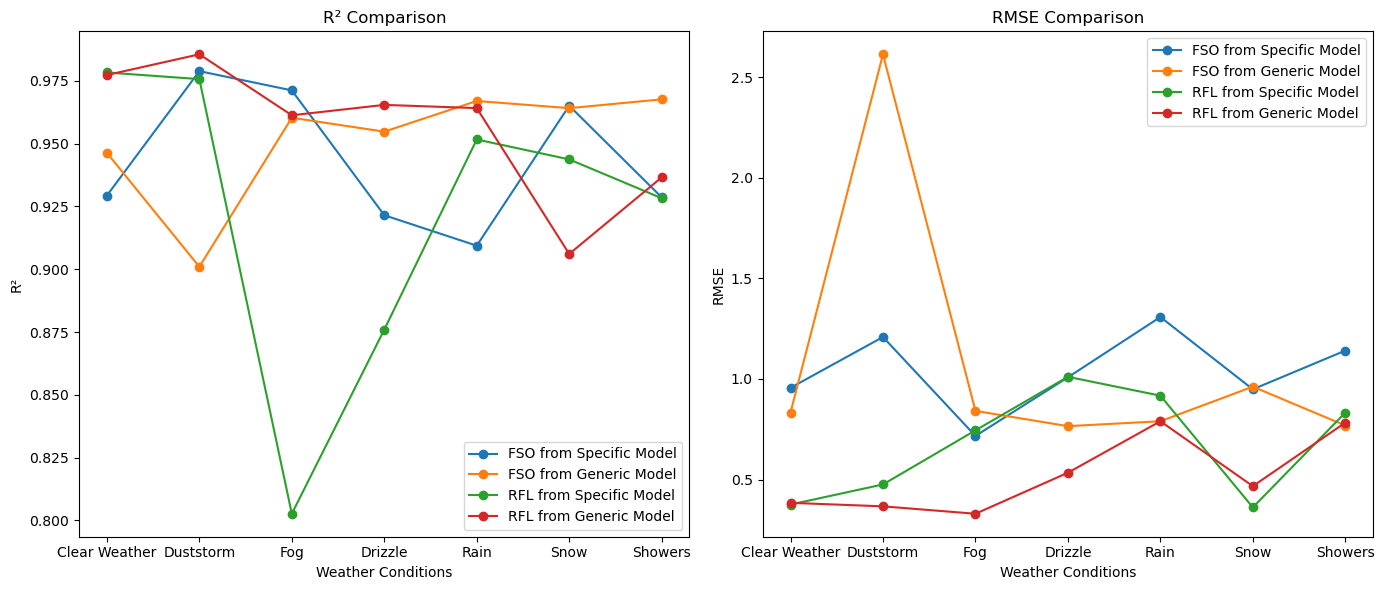

In [9]:
# 绘制对比图表
weather_conditions = ['SynopCode_0', 'SynopCode_3', 'SynopCode_4', 'SynopCode_5', 'SynopCode_6', 'SynopCode_7', 'SynopCode_8']
r2_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}
rmse_values = {"FSO from Specific Model": [], "FSO from Generic Model": [], "RFL from Specific Model": [], "RFL from Generic Model": []}

for wc in weather_conditions:
    for var in ['FSO_Att', 'RFL_Att']:
        specific_key = f"{wc}_{var}"
        overall_key = f"{specific_key}_overall"
        
        if specific_key in results:
            r2_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Specific Model"].append(results[specific_key]['rmse'])
        if overall_key in results:
            r2_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['r2'])
            rmse_values[f"{var.split('_')[0]} from Generic Model"].append(results[overall_key]['rmse'])

x_labels =['Clear Weather','Duststorm','Fog','Drizzle','Rain','Snow','Showers']
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for label, values in r2_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('R²')
plt.title('R² Comparison')
plt.legend()

plt.subplot(1, 2, 2)
for label, values in rmse_values.items():
    plt.plot(x_labels, values, marker='o', label=label)
plt.xlabel('Weather Conditions')
plt.ylabel('RMSE')
plt.title('RMSE Comparison')
plt.legend()

plt.tight_layout()
plt.show()
